In [1]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

def make_predictions_with_confidence_intervals(model, scaler, group, future_temps, look_back=6, n_bootstrap=2, alpha=0.01, n_forecasts_per_month=5):
    features = ['landed_w_kg','Cluster_Label', 'mean_temp_30m','mean_temp_10m','thetao_sfc=6',
                'thetao_sfc=7.92956018447876','thetao_sfc=9.572997093200684','thetao_sfc=11.40499973297119',
                'thetao_sfc=13.46714019775391','thetao_sfc=15.8100700378418','thetao_sfc=18.49555969238281',
                'thetao_sfc=21.59881973266602','thetao_sfc=25.21141052246094','thetao_sfc=29.44473075866699']
    
    group_scaled = scaler.transform(group[features])
    
    # Preparar X_input manteniendo la forma correcta (1, 6, 14)
    X_input = group_scaled[-look_back:].astype(np.float32)
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

    predictions = []
    for i in range(len(future_temps)):
        monthly_predictions = []
        for _ in range(n_forecasts_per_month):
            pred = model.predict(X_input)
            monthly_predictions.append(pred[0][0])
            
            future_temp_values = future_temps.iloc[i][['mean_temp_30m', 'mean_temp_10m', 'thetao_sfc=6', 
                                                       'thetao_sfc=7.92956018447876', 'thetao_sfc=9.572997093200684',
                                                       'thetao_sfc=11.40499973297119', 'thetao_sfc=13.46714019775391',
                                                       'thetao_sfc=15.8100700378418', 'thetao_sfc=18.49555969238281',
                                                       'thetao_sfc=21.59881973266602', 'thetao_sfc=25.21141052246094',
                                                       'thetao_sfc=29.44473075866699']].values.reshape(1, -1).astype(np.float32)
            
            new_record = np.hstack((pred, np.array([[group['Cluster_Label'].iloc[0]]], dtype=np.float32), future_temp_values))
            new_record_df = pd.DataFrame(new_record, columns=features)
            new_record_scaled = scaler.transform(new_record_df)  # Escalar el nuevo registro
            
            # Mantener la forma correcta al agregar el nuevo registro
            new_record_scaled = np.reshape(new_record_scaled, (1, 1, -1))
            X_input = np.append(X_input[:, 1:, :], new_record_scaled, axis=1)

        predictions.extend(monthly_predictions)
    
    predictions = np.array(predictions).reshape(-1, 1)
    # Crear un array de ceros con las mismas dimensiones que el grupo original escalado
    predictions_full = np.hstack((predictions, np.zeros((len(predictions), group_scaled.shape[1] - 1))))

    # Convertirlo a DataFrame con los nombres de columnas correctos antes de desescalar
    predictions_full_df = pd.DataFrame(predictions_full, columns=features)
    predictions_descaled = scaler.inverse_transform(predictions_full_df)[:, 0]
    
    # Bootstrap para bandas de confianza
    bootstrap_predictions = []
    for _ in range(n_bootstrap):
        X_input_bootstrap = group_scaled[-look_back:].astype(np.float32)
        X_input_bootstrap = np.reshape(X_input_bootstrap, (1, X_input_bootstrap.shape[0], X_input_bootstrap.shape[1]))

        bootstrap_pred = []
        for i in range(len(future_temps)):
            monthly_bootstrap_predictions = []
            for _ in range(n_forecasts_per_month):
                pred_boot = model.predict(X_input_bootstrap)
                monthly_bootstrap_predictions.append(pred_boot[0][0])
                
                future_temp_values = future_temps.iloc[i][['mean_temp_30m', 'mean_temp_10m', 'thetao_sfc=6', 
                                                           'thetao_sfc=7.92956018447876', 'thetao_sfc=9.572997093200684',
                                                           'thetao_sfc=11.40499973297119', 'thetao_sfc=13.46714019775391',
                                                           'thetao_sfc=15.8100700378418', 'thetao_sfc=18.49555969238281',
                                                           'thetao_sfc=21.59881973266602', 'thetao_sfc=25.21141052246094',
                                                           'thetao_sfc=29.44473075866699']].values.reshape(1, -1).astype(np.float32)
                
                new_record_boot = np.hstack((pred_boot, np.array([[group['Cluster_Label'].iloc[0]]], dtype=np.float32), future_temp_values))
                new_record_boot_df = pd.DataFrame(new_record_boot, columns=features)
                new_record_boot_scaled = scaler.transform(new_record_boot_df)  # Escalar el nuevo registro
                
                new_record_boot_scaled = np.reshape(new_record_boot_scaled, (1, 1, -1))
                X_input_bootstrap = np.append(X_input_bootstrap[:, 1:, :], new_record_boot_scaled, axis=1)

            bootstrap_pred.extend(monthly_bootstrap_predictions)
        
        bootstrap_pred = np.array(bootstrap_pred).reshape(-1, 1)
        bootstrap_pred_full = np.hstack((bootstrap_pred, np.zeros((len(bootstrap_pred), group_scaled.shape[1] - 1))))
        bootstrap_pred_full_df = pd.DataFrame(bootstrap_pred_full, columns=features)
        bootstrap_pred_descaled = scaler.inverse_transform(bootstrap_pred_full_df)[:, 0]
        bootstrap_predictions.append(bootstrap_pred_descaled)
    
    bootstrap_predictions = np.array(bootstrap_predictions)
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)
    
    return predictions_descaled, lower_bound, upper_bound



In [2]:

specie='ABULON'
cluster_label=1
path_model = f'modelos_moe/{specie}_cluster_{cluster_label}_moe_model.h5'
model = tf.keras.models.load_model(path_model)
scaler_path = f'modelos_moe/{specie}_cluster_{cluster_label}_moe_scaler.pkl'
scaler = joblib.load(scaler_path)
data = pd.read_csv('data/data.csv',low_memory=False)
# Ejemplo de uso de la función

future_temps = pd.read_csv('future_temp.csv')
future_temps = future_temps[future_temps['Cluster_Label'] == cluster_label]
future_temps['date'] = pd.to_datetime(future_temps['year'].astype(str) + '-' + future_temps['month'].astype(str))
future_temps = future_temps.sort_values(by='date')


OSError: No file or directory found at modelos_moe/ABULON_cluster_1_moe_model.h5

In [ ]:
predictions, lower_bound, upper_bound = make_predictions_with_confidence_intervals(model, scaler, data, future_temps, look_back=6, n_bootstrap=1, alpha=0.01,n_forecasts_per_month=1)


1/1 [==============================] - 0s 24ms/step


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directorio donde se guardarán los resultados
n_forecasts_per_month=1
results_dir = 'Resultados'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Expande la columna de fechas para coincidir con el número de predicciones
expanded_dates = future_temps['date'].repeat(n_forecasts_per_month).reset_index(drop=True)

# DataFrame con los datos utilizados para la gráfica
data_to_save = pd.DataFrame({
    'date': expanded_dates,
    'predictions': predictions,
    #'lower_bound': lower_bound,  # Descomenta si tienes estos datos y quieres guardarlos
    #'upper_bound': upper_bound   # Descomenta si tienes estos datos y quieres guardarlos
})

# Guardar el DataFrame en un archivo CSV
csv_path = os.path.join(results_dir, f'predicciones_{specie}_cluster_{cluster_label}.csv')
data_to_save.to_csv(csv_path, index=False)
data_to_save

,date,predictions
0,2025-01-01,-324.981342
1,2025-02-01,-21.967379
2,2025-03-01,-565.045490
3,2025-04-01,2619.872866
4,2025-05-01,1856.972466
...,...,...
955,2084-08-01,39.990107
956,2084-09-01,73.227830
957,2084-10-01,121.431406
958,2084-11-01,150.312523


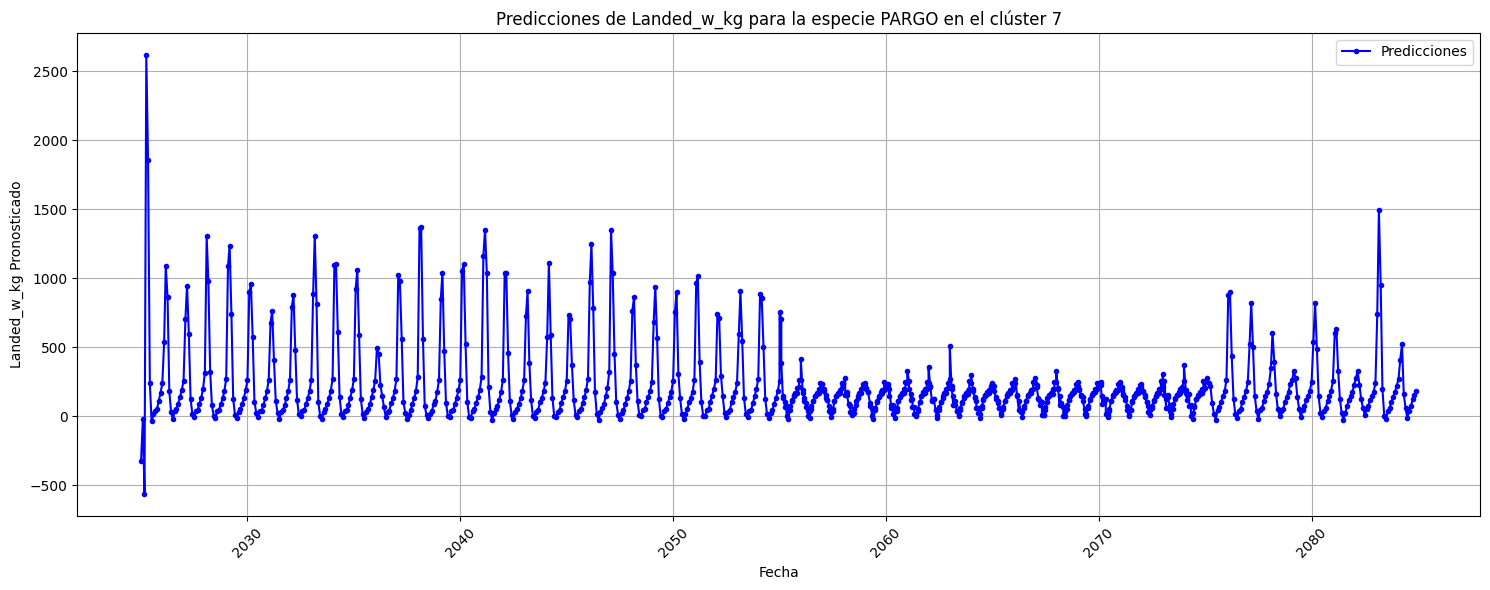

Datos guardados en Resultados/predicciones_PARGO_cluster_7.csv y figura guardada en Resultados/predicciones_PARGO_cluster_7.png


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directorio donde se guardarán los resultados
results_dir = 'Resultados'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Crear la gráfica con intervalos de confianza
plt.figure(figsize=(15, 6))

# Asegúrate de que las fechas estén alineadas con las predicciones
expanded_dates = future_temps['date'].repeat(n_forecasts_per_month).reset_index(drop=True)

# Graficar las predicciones
plt.plot(expanded_dates, predictions, marker='.', linestyle='-', color='b', label='Predicciones')

# Descomentar si tienes los intervalos de confianza y quieres graficarlos
# plt.fill_between(expanded_dates, lower_bound, upper_bound, color='gray', alpha=0.2, label='Intervalo de Confianza')

# Configurar los ejes y el título
plt.xlabel('Fecha')
plt.ylabel('Landed_w_kg Pronosticado')
plt.title(f'Predicciones de Landed_w_kg para la especie {specie} en el clúster {cluster_label}')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.tight_layout()

# Guardar la figura
fig_path = os.path.join(results_dir, f'predicciones_{specie}_cluster_{cluster_label}.png')
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Datos guardados en {csv_path} y figura guardada en {fig_path}")


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Paso 1: Preparar los Datos

# Directorio donde se encuentran los datos históricos y los datos de predicciones
results_directory = 'Resultados'
historical_data_path = 'data/data.csv'
sp = 'PARGO'
# Cargar los datos históricos
historical_data = pd.read_csv(historical_data_path)
historical_data['date'] = pd.to_datetime(historical_data['date'])
historical_data['year_month'] = historical_data['date'].dt.to_period('M')

# Filtrar los datos históricos para la especie ESMEDREGAL y calcular la suma mensual
historical_data = historical_data[historical_data['species'] == sp]
monthly_historical = historical_data.groupby('year_month')['landed_w_kg'].sum().reset_index()

# Obtener la lista de archivos de predicciones
prediction_files = [f for f in os.listdir(results_directory) if f.startswith('predicciones_') and f.endswith('.csv')]

# Leer los datos de predicción
all_predictions = []
for file in prediction_files:
    species_name = file.split('_')[1]
    
    if species_name != sp:
        continue
    
    file_path = os.path.join(results_directory, file)
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = df['date'].dt.to_period('M')
    
    # Agrupar por mes y calcular la media de las predicciones
    monthly_predictions = df.groupby('year_month')['predictions'].apply(lambda x: x.values).reset_index()
    all_predictions.append(monthly_predictions)

# Unir todas las predicciones en un solo DataFrame
predictions_df = pd.concat(all_predictions, ignore_index=True)

# Asegurarse de que las predicciones y los datos históricos tengan los mismos períodos
data = pd.merge(predictions_df, monthly_historical, on='year_month')

# Separar las variables de entrada (X) y objetivo (y)
X = np.array(data['predictions'].tolist())  # Convertir la lista de arrays en un array 2D
y = data['landed_w_kg'].values

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Paso 2: Construir la Red Neuronal

# Definir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Solo una salida para la suma mensual
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Paso 3: Entrenar el Modelo

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test)
print(f'MAE: {mae}')

# Hacer predicciones
predictions = model.predict(X_test)

# Desescalar las predicciones y las etiquetas
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# Comparar las predicciones con los valores reales
for i in range(len(predictions)):
    print(f'Predicción: {predictions[i]}, Real: {y_test[i]}')


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.